# Model Evaluation

This notebook analyzes and compares the results of all trained ML models for Nutri-Score prediction.

## Contents

1. **Data Loading** - Load all model metadata JSON files
2. **Leaderboard** - Rank models by F1-Macro score
3. **Generalization Gap** - Compare train vs validation accuracy
4. **Stability Analysis** - Evaluate cross-validation variance
5. **Efficiency Frontier** - Trade-off between performance and training time
6. **Best Model Export** - Hyperparameters of the top model

In [1]:
import json
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', '{:.4f}'.format)
sns.set_style('whitegrid')
sns.set_palette('viridis')

---
# Data Loading

Load all model metadata JSON files from the trained models directory.

In [2]:
def load_model_results(base_path: str) -> pd.DataFrame:
    """Load all model metadata JSON files and return a DataFrame."""
    pattern = base_path + "/**/*_metadata.json"
    json_files = glob.glob(pattern, recursive=True)
    
    records = []
    for filepath in json_files:
        with open(filepath, 'r') as f:
            data = json.load(f)
        
        history = data.get('training_history', {})
        train_metrics = history.get('train_metrics', {})
        val_metrics = history.get('val_metrics', {})
        cv_scores = history.get('cv_scores', {})
        
        record = {
            'Model': data.get('model_name'),
            'Train_Accuracy': train_metrics.get('accuracy'),
            'Val_Accuracy': val_metrics.get('accuracy'),
            'Precision_Macro': val_metrics.get('precision_macro'),
            'Recall_Macro': val_metrics.get('recall_macro'),
            'F1_Macro': val_metrics.get('f1_macro'),
            'F1_Weighted': val_metrics.get('f1_weighted'),
            'CV_Mean': cv_scores.get('mean'),
            'CV_Std': cv_scores.get('std'),
            'CV_Scores': cv_scores.get('scores'),
            'Training_Time': history.get('training_time'),
            'Hyperparameters': data.get('hyperparameters'),
        }
        records.append(record)
    
    df = pd.DataFrame(records)
    df = df.sort_values('F1_Macro', ascending=False).reset_index(drop=True)
    return df

In [3]:
MODELS_PATH = '../../models/trained'
df_results = load_model_results(MODELS_PATH)

print("Loaded", len(df_results), "model results")
df_results[['Model', 'F1_Macro', 'Val_Accuracy', 'CV_Mean', 'Training_Time']]

Loaded 5 model results


,Model,F1_Macro,Val_Accuracy,CV_Mean,Training_Time
0,SVM,0.8161,0.8348,0.8320,6588.1711
1,XGBoost,0.7888,0.8122,0.8114,36.8851
2,RandomForest,0.7715,0.7911,0.7905,129.7489
3,KNN,0.7507,0.7706,0.7653,12.7731
4,LogisticRegression,0.6810,0.7024,0.7061,9.1338


---
# Leaderboard

Horizontal bar plot ranking models by F1-Macro score (the primary evaluation metric for multi-class classification with imbalanced classes).

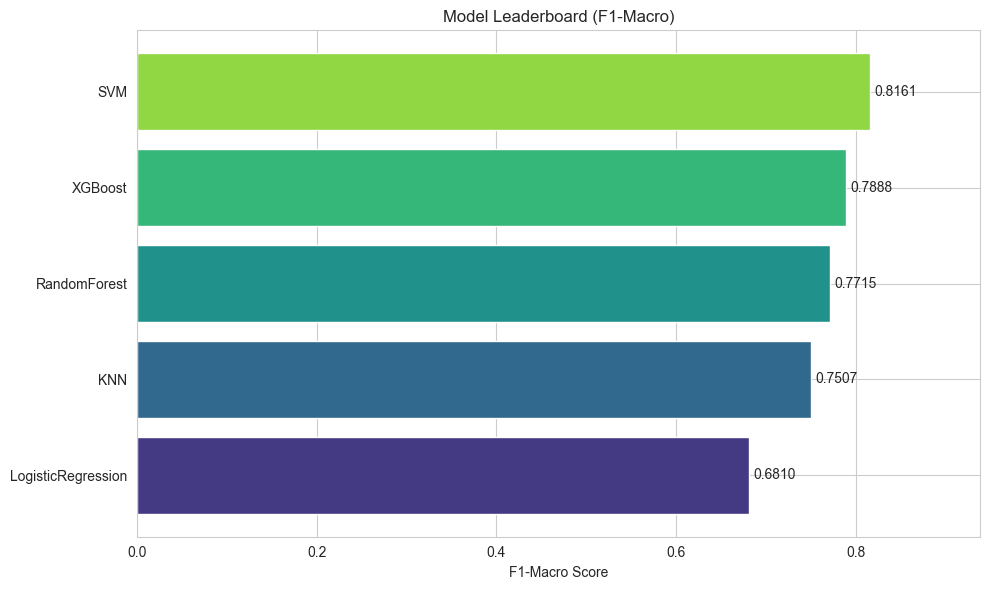

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

df_sorted = df_results.sort_values('F1_Macro', ascending=True)
colors = sns.color_palette('viridis', len(df_sorted))

bars = ax.barh(df_sorted['Model'], df_sorted['F1_Macro'], color=colors)

for bar, value in zip(bars, df_sorted['F1_Macro']):
    ax.text(value + 0.005, bar.get_y() + bar.get_height()/2, "%.4f" % value, va="center")

ax.set_xlabel('F1-Macro Score')
ax.set_title('Model Leaderboard (F1-Macro)')
ax.set_xlim(0, df_sorted['F1_Macro'].max() * 1.15)

plt.tight_layout()
plt.show()

---
# Generalization Gap

Compare training accuracy vs validation accuracy to identify potential overfitting. A large gap indicates the model memorizes training data rather than learning generalizable patterns.

In [5]:
df_gap = df_results[['Model', 'Train_Accuracy', 'Val_Accuracy']].copy()
df_gap['Gap'] = df_gap['Train_Accuracy'] - df_gap['Val_Accuracy']
df_gap = df_gap.sort_values('Gap', ascending=False)

print("Generalization Gap (Train - Val Accuracy):")
df_gap

Generalization Gap (Train - Val Accuracy):


,Model,Train_Accuracy,Val_Accuracy,Gap
3,KNN,0.9935,0.7706,0.2229
2,RandomForest,0.8913,0.7911,0.1002
1,XGBoost,0.8686,0.8122,0.0564
0,SVM,0.8615,0.8348,0.0267
4,LogisticRegression,0.7065,0.7024,0.0041


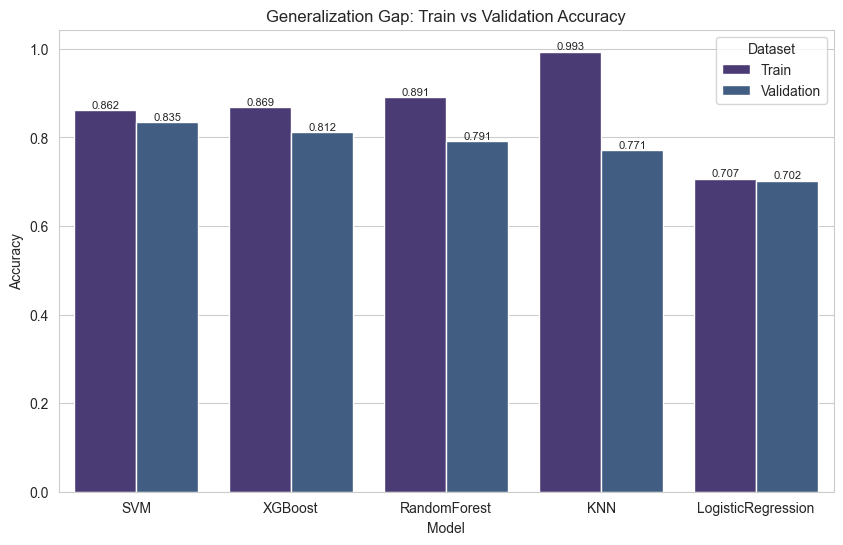

In [6]:
df_melt = df_results.melt(
    id_vars=['Model'], 
    value_vars=['Train_Accuracy', 'Val_Accuracy'],
    var_name='Dataset', 
    value_name='Accuracy'
)
df_melt['Dataset'] = df_melt['Dataset'].replace({
    'Train_Accuracy': 'Train',
    'Val_Accuracy': 'Validation'
})

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_melt, x='Model', y='Accuracy', hue='Dataset', ax=ax)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Model')
ax.set_title('Generalization Gap: Train vs Validation Accuracy')
ax.legend(title='Dataset')

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', fontsize=8)

plt.show()

---
# Stability Analysis

Boxplot of cross-validation scores helps us to assess model stability across different data folds. A lower variance value indicates more reliable performance estimates.

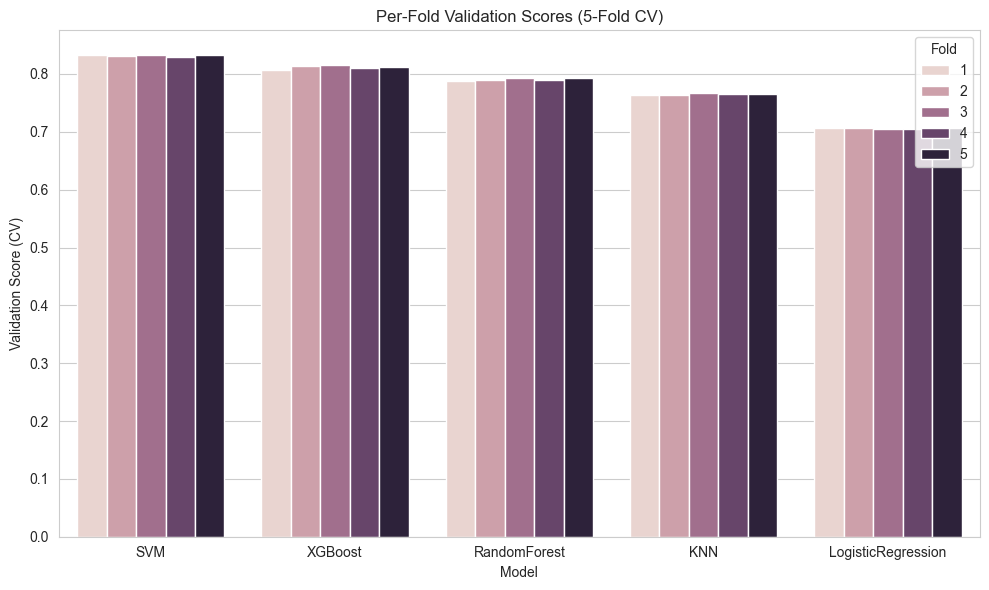

In [7]:
cv_data = []
for _, row in df_results.iterrows():
    if row['CV_Scores'] is not None:
        for fold, score in enumerate(row['CV_Scores'], start=1):
            cv_data.append({'Model': row['Model'], 'Fold': fold, 'Val_Score': score})

df_cv = pd.DataFrame(cv_data)

model_order = df_results.sort_values('CV_Mean', ascending=False)['Model'].tolist()

fig, ax = plt.subplots(figsize=(10, 6))

sns.barplot(data=df_cv, x='Model', y='Val_Score', hue='Fold', order=model_order, ax=ax)

ax.set_ylabel('Validation Score (CV)')
ax.set_xlabel('Model')
ax.set_title('Per-Fold Validation Scores (5-Fold CV)')
ax.legend(title='Fold', loc='best')

plt.tight_layout()
plt.show()

In [8]:
print("Cross-Validation Statistics:")
df_results[['Model', 'CV_Mean', 'CV_Std']].sort_values('CV_Mean', ascending=False)

Cross-Validation Statistics:


,Model,CV_Mean,CV_Std
0,SVM,0.8320,0.0013
1,XGBoost,0.8114,0.0029
2,RandomForest,0.7905,0.0022
3,KNN,0.7653,0.0012
4,LogisticRegression,0.7061,0.0010


---
# Efficiency 

Scatter plot showing the trade-off between model performance (F1-Macro) and training time. Models in the upper-left region are ideal (high performance, low training time).

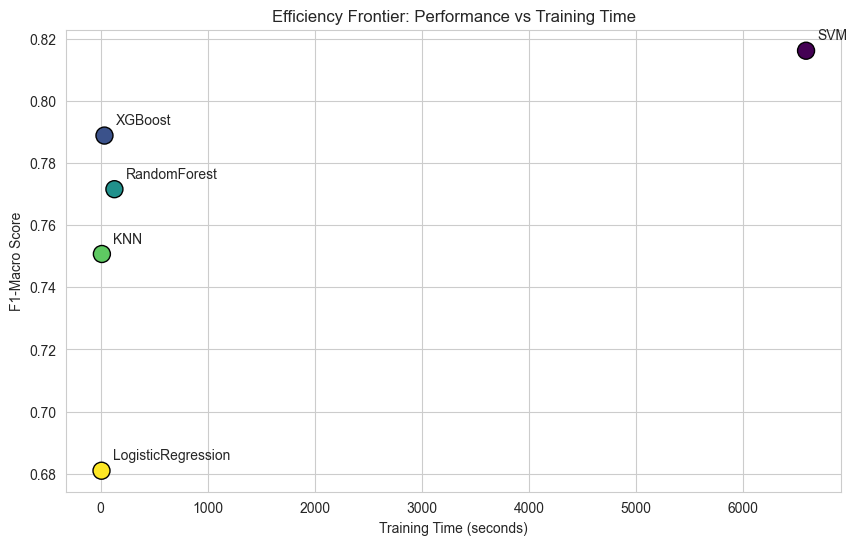

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(
    df_results['Training_Time'], 
    df_results['F1_Macro'],
    s=150,
    c=range(len(df_results)),
    cmap='viridis',
    edgecolors='black',
    linewidths=1
)

for i, row in df_results.iterrows():
    ax.annotate(
        row['Model'], 
        (row['Training_Time'], row['F1_Macro']),
        xytext=(8, 8),
        textcoords='offset points',
        fontsize=10
    )

ax.set_xlabel('Training Time (seconds)')
ax.set_ylabel('F1-Macro Score')
ax.set_title('Efficiency Frontier: Performance vs Training Time')

plt.show()

In [10]:
df_efficiency = df_results[['Model', 'F1_Macro', 'Training_Time']].copy()
df_efficiency['F1_per_Second'] = df_efficiency['F1_Macro'] / df_efficiency['Training_Time']
df_efficiency = df_efficiency.sort_values('F1_per_Second', ascending=False)

print("Efficiency Ranking (F1 per second of training):")
df_efficiency

Efficiency Ranking (F1 per second of training):


,Model,F1_Macro,Training_Time,F1_per_Second
4,LogisticRegression,0.6810,9.1338,0.0746
3,KNN,0.7507,12.7731,0.0588
1,XGBoost,0.7888,36.8851,0.0214
2,RandomForest,0.7715,129.7489,0.0059
0,SVM,0.8161,6588.1711,0.0001


---
# Best Model Export

Extract and display the hyperparameters of the best performing model (ranked by F1-Macro).

In [11]:
best_model = df_results.iloc[0]

print("Best Model:", best_model['Model'])
print("F1-Macro:", best_model['F1_Macro'])
print("Validation Accuracy:", best_model['Val_Accuracy'])
print("CV Mean:", best_model['CV_Mean'])
print("Training Time:", best_model['Training_Time'], "seconds")

Best Model: SVM
F1-Macro: 0.8161027092940039
Validation Accuracy: 0.8348221536462563
CV Mean: 0.8319556831694654
Training Time: 6588.17111 seconds


In [12]:
print("Hyperparameters:")
print(json.dumps(best_model['Hyperparameters'], indent=2))

Hyperparameters:
{
  "C": 10.0,
  "kernel": "rbf",
  "gamma": "scale",
  "degree": 3,
  "class_weight": "balanced",
  "probability": true,
  "cache_size": 2000,
  "max_iter": -1,
  "random_state": 42
}


---
# Summary

Complete metrics comparison across all models.

In [13]:
summary_cols = [
    'Model', 'F1_Macro', 'F1_Weighted', 'Val_Accuracy', 
    'Precision_Macro', 'Recall_Macro', 'CV_Mean', 'CV_Std', 'Training_Time'
]
df_results[summary_cols]

,Model,F1_Macro,F1_Weighted,Val_Accuracy,Precision_Macro,Recall_Macro,CV_Mean,CV_Std,Training_Time
0,SVM,0.8161,0.8362,0.8348,0.8126,0.8208,0.8320,0.0013,6588.1711
1,XGBoost,0.7888,0.8100,0.8122,0.7967,0.7865,0.8114,0.0029,36.8851
2,RandomForest,0.7715,0.7909,0.7911,0.7719,0.7724,0.7905,0.0022,129.7489
3,KNN,0.7507,0.7696,0.7706,0.7554,0.7485,0.7653,0.0012,12.7731
4,LogisticRegression,0.6810,0.7053,0.7024,0.6786,0.6852,0.7061,0.0010,9.1338
